## Import relevant packages

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table, vstack
import pandas as pd
import lmfit

## Enter the ALMA data from [`Maeda et al. 2023`](https://ui.adsabs.harvard.edu/abs/2023ApJ...945L...3M/abstract)

In [38]:
# days since explosion
phase = np.array([4.1, 7.1, 17.1, 21.0, 198.6, 213.5, 306.2, 1024.4, 1364.4, 4.1, 6.2, 17.1, 198.6, 1364.4, 1217, 1217])

# frequency of each observation (GHz)
freq = np.array([100.0, 100.0, 100.0, 93.5, 100.0, 92.1, 103.0, 92.1, 100.0, 250.0, 250.0, 250.0, 250.0, 250.0, 6.5, 6.3])

# fluxes at each time/frequency (mJy)
flux = np.array([4.25, 7.42, 9.05, 7.41, 0.336, 0.322, 0.264, 1.128, 0.955, 4.21, 4.32, 2.49, 0.120, 0.286, 9.1, 8.7])

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.array([0.22, 0.38, 0.46, 0.99, 0.026, 0.036, 0.044, 0.069, 0.093, 0.43, 0.44, 0.28, 0.022, 0.067, 0.9, 1.3])

# telescope observation was made with
alma = np.array(['ALMA']*14)
vla = np.array(['VLA'])
emerlin = np.array(['e-MERLIN'])
telescope = np.concatenate((alma, vla, emerlin))

table = np.column_stack((phase, freq, flux, flux_err, telescope))
data = Table(table, names=['time', 'freq', 'flux', 'flux_err', 'telescope'])
data['time'] = data['time'].astype(float)
data['freq'] = data['freq'].astype(float)
data['flux'] = data['flux'].astype(float)
data['flux_err'] = data['flux_err'].astype(float)

## Define plotting functions:

In [4]:
def plot_data(ax, sm, data, mode, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ALMA':'o', 'e-MERLIN':'d'}

    for row in data:
        if mode == 'lc':
            x = row['time']
            # set marker color based on frequency
            freq = row['freq']
            colorval = sm.to_rgba(freq)
        if mode == 'sed':
            x = row['freq']
            # set marker color based on time
            time = row['time']
            colorval = sm.to_rgba(time)

        telescope = row['telescope']
        marker = telescope_marker_dict[telescope]
        
        if scaled:
            flux = row['scaled_flux']
            err = row['scaled_flux_err']
        else:
            flux = row['flux']
            err = row['flux_err']

        ax.errorbar(x, flux, yerr=err, marker=marker, c=colorval)
    return

def make_plot(data, mode, title='', xlabel='', ylabel='', cbar=True, scaled=False, model=None, params=None, model_name=None, plot_models=False):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    if cbar:
        # get the scalar map, plot the data using the plot_data function
        sm = cmap_setup(mode)
        plot_data(ax, sm, data, mode, scaled=scaled)

        # set up colorbar
        if mode == 'lc':
            fig.colorbar(sm, fraction=0.046, label=r'$\nu$ [GHz]')
        elif mode == 'sed':
            fig.colorbar(sm, fraction=0.046, label='time [Days]')
    else:
        sm = None
        plot_data(ax, sm, data, mode, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    #Label axes, set axis limits etc.
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if scaled:
        ax.set_ylabel('Scaled Flux Density (mJy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel(ylabel)

    if mode == 'lc':
        x = data['time']
    elif mode == 'sed':
        x = data['freq']

    if model!=None:
        plot_model(model, params, x, ax, model_name)


def cmap_setup(mode, cmap='viridis', min_freq=0, max_freq=300, min_time=0, max_time=2000):
    '''
    color markers by frequency/time
    '''
    if mode == 'lc':
        freq_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    elif mode == 'sed':
        time_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_time, vmax=max_time)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    
    return sm   


# define model plotting function to be incorporated into makeplot()
def plot_model(model, params, x, ax, label):
    fit = model(x, *params)
    ax.plot(x, fit, label=label)
    ax.legend()
    return

## Recreate ALMA data plots:

/tmp/ipykernel_31301/2094903212.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  time_cmap = plt.cm.get_cmap(cmap)
/tmp/ipykernel_31301/2094903212.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, fraction=0.046, label='time [Days]')
/tmp/ipykernel_31301/2094903212.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  freq_cmap = plt.cm.get_cmap(cmap)
/tmp/ipykernel_31301/2094903212.py:40: Matp

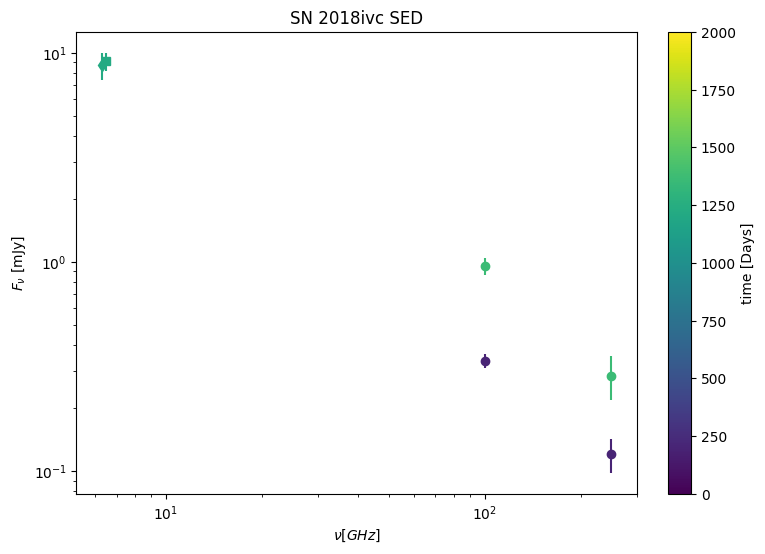

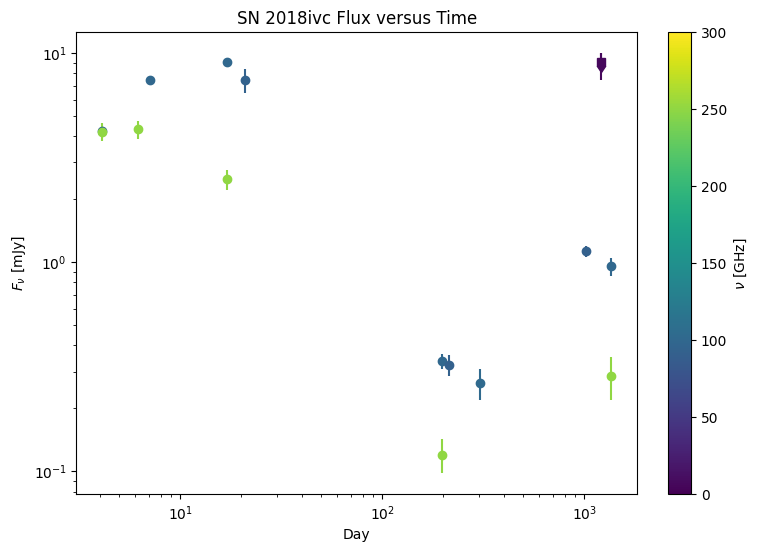

In [5]:
# Fig 2, SED of SN 2018ivc on day ~1300
SED_data = Table(names=['time', 'freq', 'flux', 'flux_err', 'telescope'], dtype=['float64', 'float64', 'float64', 'float64', 'S'])
for i in data:
    if i['time'] == 1217.0:
        SED_data.add_row(i)
    if i['time'] == 1364.4:
        SED_data.add_row(i)
    if i['time'] == 198.6:
        SED_data.add_row(i)
make_plot(SED_data, mode='sed', title='SN 2018ivc SED', xlabel=r'$\nu [GHz]$', ylabel=r'$F_{\nu}$ [mJy]')


# Fig. 3, Radio lightcurves of SN 2018ivc
make_plot(data, mode='lc', title='SN 2018ivc Flux versus Time', xlabel='Day', ylabel=r'$F_{\nu}$ [mJy]')

## Extrapolate by performing my own fit:

Now that we have loaded in all of the data, we'll first want to determine a spectral index at given epochs. Since we are dealing with non-thermal emission here, the flux density should have the relation:
$$ F_{\nu} = \nu^{\alpha} $$
Since we have ALMA (100 and 250 GHz) and VLA data (~10 to 30 GHz) at roughly the same epoch, we should be able to extrapolate the expected flux densities at the VLA frequencies from the ALMA data

In [58]:
# baisc power law function
def powerlaw(x, F0, alpha):
    F = F0 * (x ** alpha) 
    return F

# calculate spectral index based on subset of data from a given epoch. Returns a tuple containing alpha and its associated uncertainty
def alpha_calc(data):
    freq = data['freq']
    flux = data['flux']
    flux_err = data['flux_err']

    alpha, pcov = curve_fit(powerlaw, freq, flux, sigma=flux_err, absolute_sigma=True)
    
    alpha = alpha[1]
    alpha_err = np.sqrt(np.diag(pcov))[1]
    
    return alpha, alpha_err

![Alt Text](/home/billee/NRAO/SN2018ivc_summer/SN2018ivc-data-table.png)

Based on the table above, we can group the data into a few epochs, and solve for the spectral index at these epochs

In [49]:
# alpha at 4 days:
data_4 = data[data['time'] == 4.1]
alpha, alpha_err = alpha_calc(data_4)
print("alpha at 4 days = %.2f+/-%.2f"%(alpha, alpha_err))

#alpha at 17 days:
data_17 = data[data['time'] == 17.1]
alpha, alpha_err = alpha_calc(data_17)
print("alpha at 17 days = %.2f+/-%.2f"%(alpha, alpha_err))

#alpha at ~200 days:
data_200 = data[data['time'] == 198.6]
alpha, alpha_err = alpha_calc(data_200)
print("alpha at 200 days = %.2f+/-%.2f"%(alpha, alpha_err))

# alpha at ~1000 days:
data_1000 = data[data['time'] >= 1000]
alpha, alpha_err = alpha_calc(data_1000)
print("alpha at 1000 days = %.2f+/-%.2f"%(alpha, alpha_err))

alpha at 4 days = -0.01+/-0.12
alpha at 17 days = -1.41+/-0.13
alpha at 200 days = -1.12+/-0.22
alpha at 1000 days = -0.83+/-0.03


Let's try solving for the spectral energy density at ~1000 days. To really do this properly, I should fit for both $F_0$ and $\alpha$. We can do this with lmfit:

In [91]:
# create the model object
model = lmfit.Model(powerlaw)

# apply the previously created parameters dictionary to this specific model
params = model.make_params(F0=dict(value=40, min=10, max = 150), 
                           alpha=dict(value=-0.5, min=-1.0, max=5.0))

# define independent and dependent variables
x_data = data_1000['freq']
y_data = data_1000['flux']

# Perform the least squares minimization
leastsqs = model.fit(y_data, params, x=x_data)

# Inspect the fit
# print(leastsqs.fit_report())

# Access the best-fit parameter values
print("Best-fit parameters:")
leastsqs.params

Best-fit parameters:


name,value,standard error,relative error,initial value,min,max,vary
F0,39.7250570,5.12009821,(12.89%),40,10.0000000,150.000000,True
alpha,-0.80620617,0.06702077,(8.31%),-0.5,-1.00000000,5.00000000,True


From these values, we can exptrapolate the expected values at the frequencies of my VLA data. First, input the frequencies and times of each observation into a data table.

In [94]:
# create another data table with the data from my project:
# observation type:
# 6211, 6355, 6488, 5859, 6035, 7037, 6759, 7214
observation = np.array(['KuD', 'XD', 'CD', 'KD', 'KaD', 'KA', 'XA', 'KaA'])

# days since explosion
phase = np.array([1363.2, 1365.1, 1368.1, 1369.2, 1369.1, 1688.1, 1689.9, 1702.2])

# frequency of each observation (GHz)
freq = np.array([15.0, 10.0, 6.0, 22.0, 33.0, 22.0, 10.0, 33.0])

# fluxes at each time/frequency (mJy)
flux = np.zeros(8)

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.zeros(8)

# telescope observation was made with
telescope = np.array(['VLA']*8)

table = np.column_stack((observation, phase, freq, flux, flux_err, telescope))
expected_vals = Table(table, names=['observation', 'time', 'freq', 'flux', 'flux_err', 'telescope'])
expected_vals['time'] = expected_vals['time'].astype(float)
expected_vals['freq'] = expected_vals['freq'].astype(float)
expected_vals['flux'] = expected_vals['flux'].astype(float)
expected_vals['flux_err'] = expected_vals['flux_err'].astype(float)
expected_vals

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.0,0.0,0.0,VLA
XD,1365.1,10.0,0.0,0.0,VLA
CD,1368.1,6.0,0.0,0.0,VLA
KD,1369.2,22.0,0.0,0.0,VLA
KaD,1369.1,33.0,0.0,0.0,VLA
KA,1688.1,22.0,0.0,0.0,VLA
XA,1689.9,10.0,0.0,0.0,VLA
KaA,1702.2,33.0,0.0,0.0,VLA


Now, calculate the expected values based on the parameters solved for with lmfit. **Don't forget to add in uncertainties later!! Not quite sure how to incorporate them.**

In [95]:
F0 = leastsqs.params['F0'].value
alpha = leastsqs.params['alpha'].value
alpha_err = leastsqs.params['alpha'].stderr

for row in expected_vals:
    freq = row['freq']
    row['flux'] = powerlaw(freq, F0, alpha)

expected_vals

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.0,4.476024928339946,0.0,VLA
XD,1365.1,10.0,6.206665732342612,0.0,VLA
CD,1368.1,6.0,9.369451939705568,0.0,VLA
KD,1369.2,22.0,3.286964984795602,0.0,VLA
KaD,1369.1,33.0,2.3704413681986094,0.0,VLA
KA,1688.1,22.0,3.286964984795602,0.0,VLA
XA,1689.9,10.0,6.206665732342612,0.0,VLA
KaA,1702.2,33.0,2.3704413681986094,0.0,VLA


/tmp/ipykernel_31301/2094903212.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  time_cmap = plt.cm.get_cmap(cmap)
/tmp/ipykernel_31301/2094903212.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, fraction=0.046, label='time [Days]')


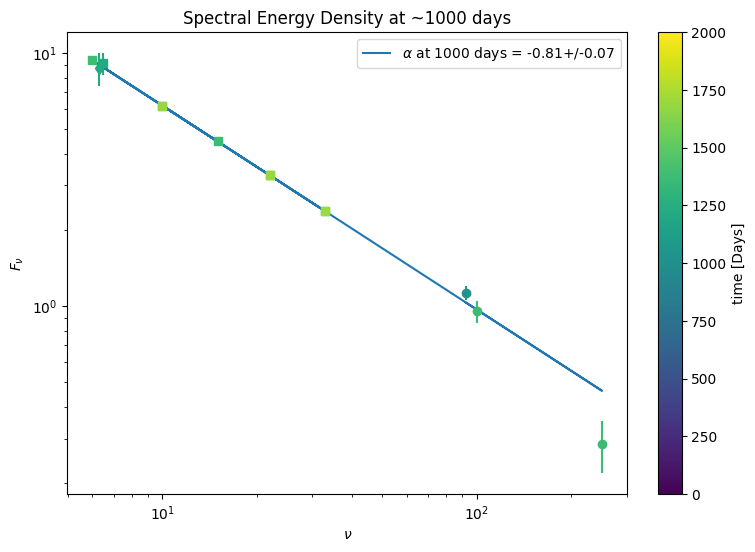

In [87]:
# combine the two tables
combined_table = vstack([data_1000, expected_vals])
alpha = leastsqs.params['alpha'].value
alpha_err = leastsqs.params['alpha'].stderr

# plot the data along with the power law model
make_plot(combined_table, 'sed', title='Spectral Energy Density at ~1000 days', xlabel=r'$\nu$', ylabel=r'$F_{\nu}$', cbar=True, scaled=False, model=powerlaw, params=[F0, alpha], model_name=r"$\alpha$" + " at 1000 days = %.2f+/-%.2f"%(alpha, alpha_err))

# Derive expected flux densities for most recent VLA A config data by scaling to one frequency:

    - scale ALMA data to one frequency
    - solve for the time dependence of the ALMA data
    - extrapolate out a year based on that time dependence
    - scale back to the VLA frequencies